# TenPy Introduction

Here, we present an introduction to the use of Python's [TenPy](https://tenpy.readthedocs.io/en/latest/index.html) package, which is useful for implementations of algorithms like density matrix renormalization group (DMRG) and time-evolving block decimation (TEBD).

In this document, we show some of the basics for how to use TenPy, namely building a model for a spin chain and using DMRG to find and analyze properties of the ground state. To begin, we first install TenPy onto our Colab session and import some useful packages.

In [6]:
! pip install physics_tenpy # the name 'tenpy' was already taken! be sure you
                            # don't install 'tenpy' to reduce import errors

Defaulting to user installation because normal site-packages is not writeable


In [7]:
# importing

from tenpy.models.lattice import Chain # bare chain package

from tenpy.networks import site # package that has all sorts of site structures

from tenpy.models.spins import SpinModel # general model for spin lattices

from tenpy.models.spins import SpinChain # special model for a spin chain that
                                         # allows us to bypass the construction
                                         # of a chain lattice

from tenpy.networks.mps import MPS # package to construct a matrix product state
                                   # for a given model

from tenpy.algorithms import dmrg # you know what it be

## Building a Lattice

Here, we construct a [Chain](https://tenpy.readthedocs.io/en/latest/reference/tenpy.models.lattice.Chain.html) lattice object to feed into our model. Here, we use the [SpinSite](https://tenpy.readthedocs.io/en/latest/reference/tenpy.networks.site.SpinSite.html) as the sites of our lattice, where the S parameter used below in our site initialization defines the spin value.


In [8]:
L = 10 # number of sites in our lattice
bc = 'open' # open boundary conditions term, for periodic we put 'periodic'


spin_site = site.SpinSite(0.5, 'None') # we want a spin 1/2 site with no
                                       # conservation laws


lat = Chain(L=L, site=spin_site, bc=bc) # building our lattice!

## Building a Model

Here, we insert out lattice built above into the [SpinModel](https://tenpy.readthedocs.io/en/latest/reference/tenpy.models.spins.SpinModel.html#tenpy.models.spins.SpinModel) to create our model. Here, we implement the transverse field Ising model

$$
\hat{H} =  \sum_{\langle i,j \rangle }  J S_i^z S_j^z  - \sum_i g S_i^x
$$

Here, we use the SpinModel, but if we know we want a SpinChain, there is a [SpinChain](https://tenpy.readthedocs.io/en/latest/reference/tenpy.models.spins.SpinChain.html) model already premade for us, neat!

The SpinModel module can be used in a couple different ways. For example, we can just insert our lattice into the model.

In [9]:
J = 1
g = 1

model_params = {
    'lattice' : lat,
    'Jz' : J,
    'hx' : g
}

model = SpinModel(model_params=model_params)

Or we can insert parameters into the model like

In [10]:
model_params = {
    'L' : L,
    'bc_x' : bc,
    'S' : 0.5,
    'lattice' : 'Chain',
    'Jz' : J,
    'hx' : g*J
}

model = SpinModel(model_params=model_params)

## Initial Matrix Product State

Now that we have a model, we can make our initial MPS and then we will be ready for DMRG. This initial MPS can be random, uniform, or a structured guess based on symmetries of our model. Here, we use the [MPS](https://tenpy.readthedocs.io/en/latest/reference/tenpy.networks.mps.MPS.html) module, where we can construct our matrix product state using just strings!

In [11]:
product_state = ["up"]*L # yep, it's that easy!

psi = MPS.from_product_state(model.lat.mps_sites(),
                             product_state,
                             bc=model.lat.bc_MPS) # okay, we had to do this
                                                  # extra step, still easy!

## DMRG Time

Now we have all the pieces to run a DMRG algorithm. We will need to set some parameters for the DMRG, but other than that we are home free! The only thing here that I think could be unclear is the [Mixer](https://tenpy.readthedocs.io/en/latest/reference/tenpy.algorithms.mps_common.Mixer.html#cfg-option-Mixer.amplitude) in dmrg_params. But, [here](https://tenpy.readthedocs.io/en/latest/notebooks/12_dmrg_mixer.html) is a whole page about the mixer!

In [12]:
dmrg_params = {

'trunc_params' : { # parameters for truncation of stuff
    'chi_max' : 100, # maximum virtual/bond dimension
    'svd_min' : 1e-7 # minimum value of singular values before we truncate them
},

'max_E_err' : 1e-5, # maximum error in energies as we make variations

'mixer' : True # something that helps us avoid getting stuck in local minima
               # by expanding the local bond dimension for the some number
               # of initial sweeps. Think of this like annealing in
               # Metropolis (Monte-Carlo) algorithms. True gives the default
               # class of Mixer

}

info = dmrg.run(psi,model,dmrg_params) # dmrg returns all sorts of statistics
                                       # to info




And that's it, we've run a DMRG algorithm! There are all sorts of things that we can do now. One example is a phase space plot! Let's look at a [TFIChain](https://tenpy.readthedocs.io/en/latest/reference/tenpy.models.tf_ising.TFIChain.html) and if we can see the different phases. ***This section has no comments/explainations***, see if you can figure out everything that's going on!

This section is motivated by [this](https://juliaphysics.github.io/PhysicsTutorials.jl/tutorials/general/quantum_ising/quantum_ising.html) analysis of the transverse field ising model from the developers of Julia, a C++ based programing language for scientific computing.

We are still using the SpinChain here, but the same work with the TFIChain should produce the same results.

It is probably best if you try to run computationally intensive TenPy code as a script (.py file) because there can be quite a bit of computational overhead to manage the Jupyter (.ipynb) environment as we let the computer go compute. Of course, you can always do tests here with smaller finite systems to get an idea of how everything works. You got this!

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from time import time



res = 11
J = -1
L=10

gs = np.linspace(-1,1,res)

x_mag = np.zeros((res,res),dtype=float)



def get_ground(L,J,g) :

  model_param = {
      'L' : L,
      'bc_MPS' : 'finite',
      'conserve' : 'None',
      'Jz' : J,
      'hx' : g
  }

  model = SpinChain(model_param)

  base_states = ['up','down']

  product_state = [np.random.choice(base_states) for i in range(L)]

  psi = MPS.from_product_state(model.lat.mps_sites(),
                               product_state,
                               bc=model.lat.bc_MPS)


  dmrg_params = {

      'trunc_params' : {
          'chi_max' : 100,
          'svd_min' : 1e-4
      },

      'max_E_err' : 1e-5,

      'mixer' : True
  }

  print("Running DMRG...")
  t_i = time()
  info = dmrg.run(psi,model,dmrg_params)
  t_f = time()
  print(f"DMRG finished | Time : {np.round(t_f-t_i,2)} sec | chi : {psi.chi}")

  return psi, info



for jj in range(res) :
  psi, info = get_ground(L=L,J=J,g=gs[jj])

  x_mag[:,jj] = np.mean(psi.expectation_value('Sx'))








Running DMRG...
DMRG finished | Time : 0.36 sec | chi : [2, 4, 6, 8, 8, 8, 6, 4, 2]
Running DMRG...
DMRG finished | Time : 0.44 sec | chi : [2, 4, 8, 11, 11, 11, 8, 4, 2]
Running DMRG...
DMRG finished | Time : 0.55 sec | chi : [2, 4, 8, 12, 12, 12, 8, 4, 2]
Running DMRG...
DMRG finished | Time : 0.54 sec | chi : [2, 4, 8, 13, 13, 13, 8, 4, 2]
Running DMRG...


final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=2.31e-05


DMRG finished | Time : 0.8 sec | chi : [2, 4, 7, 9, 11, 9, 7, 4, 2]
Running DMRG...
DMRG finished | Time : 0.16 sec | chi : [1, 1, 1, 1, 1, 1, 1, 1, 1]
Running DMRG...


final DMRG state not in canonical form up to norm_tol=1.00e-05: norm_err=2.31e-05


DMRG finished | Time : 0.72 sec | chi : [2, 4, 7, 9, 11, 9, 7, 4, 2]
Running DMRG...
DMRG finished | Time : 0.47 sec | chi : [2, 4, 8, 13, 13, 13, 8, 4, 2]
Running DMRG...
DMRG finished | Time : 0.45 sec | chi : [2, 4, 8, 12, 12, 12, 8, 4, 2]
Running DMRG...
DMRG finished | Time : 0.42 sec | chi : [2, 4, 8, 11, 11, 11, 8, 4, 2]
Running DMRG...
DMRG finished | Time : 0.45 sec | chi : [2, 4, 6, 8, 8, 8, 6, 4, 2]


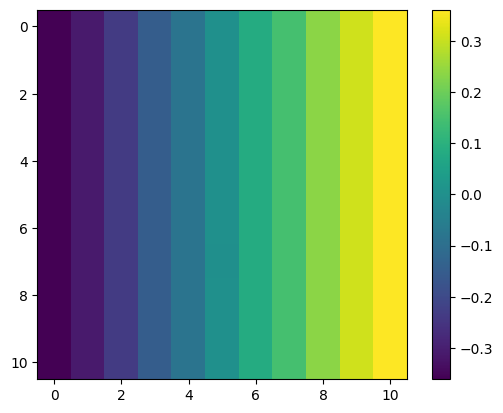

In [14]:
plt.imshow(x_mag)
plt.colorbar()